# Fafchamps (1993): "Sequential Labor Decisions Under Uncertainty: An Estimable Household Model of West-African Farmers"

In this notebook, I solve the dynamic model in [Fafchamps (1993)](https://www.jstor.org/stable/2951497?seq=1#metadata_info_tab_contents) and simulate the model.
I am responsible for all errors in this document.

## Research questions

In Burkina Faso, it has been observed that, while farmers complain that they face labor shortages, the level of agricultural labor effort is low.
The author hypothesizes that farmers suppress their labor input in one season (planting season) since too much labor input in this season leads to too much crop growth and hence to labor shortages in the following season (weeding season).
To corroborate this hypothesis, this paper answers the following questions:

- How flexible is agricultural production (ie. how much is the elasticity of substitution between labor and crop growth)?
- How much is the intertemporal substitutability in consumption and leisure?

## Model

\begin{equation*}
    \max_{l_1} E_{\theta_1} \left[ \max_{l_2} E_{\theta_2} \left[ \frac{1}{1 - R} \left\{ \delta \left(\gamma \left(1 - l_1 \right)^{\sigma} + (1 - \gamma) \left(1 - l_2 \right)^{\sigma} \right)^{\frac{\rho}{\sigma}} + (1 - \delta) y_3^{\rho} \right\}^{\frac{1 - R}{\rho}} \right] \right]
\end{equation*}

subject to the stochastic laws of motion

\begin{align*}
    y_1 &= A e^{\theta_0} \\
    y_2 &= \left(\alpha y_1^{r_1} + (1 - \alpha) l_1^{r_1} \right)^{\frac{1}{r_1}} e^{\theta_1} \\
    y_3 &= b \left(\beta y_2^{r_2} + (1 - \beta) l_2^{r_2} \right)^{\frac{1}{r_2}} e^{\theta_2}.
\end{align*}

Euler equations are

\begin{align}
    E_{\theta_1} \left[ E_{\theta_2} \left[ \left\{ \delta \left(\gamma \left(1 - l_1(A, \theta_0) \right)^{\sigma} + (1 - \gamma) \left(1 - l_2(A, \theta_0, l_1, \theta_1) \right)^{\sigma} \right)^{\frac{\rho}{\sigma}} + (1 - \delta) y_3^{\rho} \right\}^{\frac{1 - R}{\rho} - 1} \cdot
    \left\{ - \delta \left(\gamma \left(1 - l_1(A, \theta_0) \right)^{\sigma} + (1 - \gamma) \left(1 - l_2(A, \theta_0, l_1, \theta_1) \right)^{\sigma} \right)^{\frac{\rho}{\sigma} - 1} \gamma (1 - l_1(A, \theta_0))^{\sigma - 1} + (1 - \delta) y_3^{\rho - 1} \frac{\partial y_3}{\partial y_2} \frac{\partial y_2}{\partial l_1} \right\} \right] \right] = 0 \\
    E_{\theta_2} \left[ \left\{ \delta \left(\gamma \left(1 - l_1(A, \theta_0) \right)^{\sigma} + (1 - \gamma) \left(1 - l_2(A, \theta_0, l_1, \theta_1) \right)^{\sigma} \right)^{\frac{\rho}{\sigma}} + (1 - \delta) y_3^{\rho} \right\}^{\frac{1 - R}{\rho} - 1} \cdot 
    \left\{ - \delta \left(\gamma \left(1 - l_1(A, \theta_0) \right)^{\sigma} + (1 - \gamma) \left(1 - l_2(A, \theta_0, l_1, \theta_1) \right)^{\sigma} \right)^{\frac{\rho}{\sigma} - 1} (1 - \gamma) (1 - l_2(A, \theta_0, l_1, \theta_1))^{\sigma - 1} + (1 - \delta) y_3^{\rho - 1} \frac{\partial y_3}{\partial l_2} \right\} \right] = 0,
\end{align}

where

\begin{align*}
    \frac{\partial y_3}{\partial y_2} &= b \left(\beta y_2^{r_2} + (1 - \beta) l_2^{r_2} \right)^{\frac{1}{r_2} - 1} \beta y_2^{r_2 - 1} e^{\theta_2} \\
    \frac{\partial y_2}{\partial l_1} &= \left(\alpha y_1^{r_1} + (1 - \alpha) l_1^{r_1} \right)^{\frac{1}{r_1} - 1} \alpha y_1^{r_1 - 1} e^{\theta_1} \\
    \frac{\partial y_3}{\partial l_2} &= b \left(\beta y_2^{r_2} + (1 - \beta) l_2^{r_2} \right)^{\frac{1}{r_2} - 1} (1 - \beta) l_2^{r_2 - 1} e^{\theta_2}.
\end{align*}


### What does the model ignore?

- Dynamism across agricultural seasons (eg. saving, land investment, etc.)
- Serial correlations of shocks

## Identification (and additional assumptions)

## Simulating data

To simulate data, I need to find optimal policies satisfying Euler equations above.
For this, I need to evaluate expectations.
As in the paper, I use a Gauss-Hermite quadrature with six nodes for each random shock to evaluate each expectation.

Given $\theta_0$ (and $A$), the first-period labor input $l_1$ is determined as follows:

- At each $\theta_1$ node, with some $l_1$, I obtain $l_2(A, \theta_0, l_1, \theta_1)$ from (2);
- I then substitute these $l_1$ and $l_2(A, \theta_0, l_1, \theta_1)$ into (1);
- Find $l_1$ with which the steps above make the left-hand side of (1) zero.

As in the data, the information that farmers have includes the followings:

- Land ($A$);
- Labor inputs in the first period ($l_1$) and in the second period ($l_2$);
- Final output ($y_3$).

As argued in the paper, I assume that farmers' priors are the same as true variances of shocks.
Hence, in the expectation calculations, I use the true variances.

In [4]:
import numpy as np
import quantecon
import scipy
import scipy.optimize
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
delta = 0.76839
sigma = 0.95534
rho = 0.72795
gamma = 0.5
R = 0.5
alpha = 0.999
r1 = -4.32815
beta = 0.46377
r2 = -0.05717
b = 2.95781

sigma0 = 0.86582
sigma1 = 1.15954
sigma2 = 0.62278


In [3]:
# param = [delta, sigma, rho, alpha, r1, beta, r2, b, sigma0, sigma1, sigma2]

In [6]:
# Set parameters of the distribution of A so that the mean is 0.82, the average area/head (ha) in Sahelian Zone, Woure
mu_A = -0.3
sigma_A = np.sqrt(2 * (np.log(0.82) - mu_A))

In [7]:
N = 1000
np.random.seed(123)

For ease, I use standard normal random variables $u_0$, $u_1$, and $u_2$ that are related to shocks by $\theta_0 = \sigma_0 u_0$, $\theta_1 = \sigma_1 u_1$, and $\theta_2 = \sigma_2 u_2$.

In [9]:
A = np.exp(np.random.normal(mu_A, sigma_A, N))
u0 = np.random.normal(0, 1, N)
u1 = np.random.normal(0, 1, N)
u2 = np.random.normal(0, 1, N)

In [10]:
def Euler2_function(l2, u1, l1, u0, A, param):

    delta, sigma, rho, alpha, r1, beta, r2, b, sigma0, sigma1, sigma2 = param

    node, weight = quantecon.quad.qnwnorm(6)
    y1 = A * np.exp(u0 * sigma0)
    y2 = (alpha * y1 ** r1 + (1 - alpha) * l1 ** r1) ** (1 / r1) * np.exp(u1 * sigma1)
    y3 = b * (beta * y2 ** r2 + (1 - beta) * l2 ** r2) ** (1 / r2) * np.exp(node * sigma2)
    dy3_dl2 = b * (beta * y2 ** r2 + (1 - beta) * l2 ** r2) ** (1 / r2 - 1) * \
        (1 - beta) * l2 ** (r2 - 1) * np.exp(node * sigma2)

    return(
        np.dot(
            weight, 
            (
                delta * (gamma * (1 - l1) ** sigma + (1 - gamma) * (1 - l2) ** sigma) ** (rho / sigma) + \
                (1 - delta) * y3 ** rho
            ) ** ((1 - R) / rho - 1) * (
                - delta * (gamma * (1 - l1) ** sigma + (1 - gamma) * (1 - l2) ** sigma) ** (rho / sigma - 1) * \
                (1 - gamma) * (1 - l2) ** (sigma - 1) + (1 - delta) * y3 ** (rho - 1) * dy3_dl2
            )
        )
    )

def Euler1_function(l1, A, u0, param):

    delta, sigma, rho, alpha, r1, beta, r2, b, sigma0, sigma1, sigma2 = param

    node, weight = quantecon.quad.qnwnorm(6)
    l2_node = np.zeros(6)
    for u1_node, i in zip(node, range(6)):
        l2_node[i] = scipy.optimize.brentq(Euler2_function, 1e-14, 1 - 1e-14, args = (u1_node, l1, u0, A, param))

    node, weight = quantecon.quad.qnwnorm((6, 6))

    u1 = node[:,0]
    u2 = node[:,1]
    l2_node_ext = np.tile(l2_node, 6)

    y1 = A * np.exp(u0 * sigma0)
    y2 = (alpha * y1 ** r1 + (1 - alpha) * l1 ** r1) ** (1 / r1) * np.exp(u1 * sigma1)
    y3 = b * (beta * y2 ** r2 + (1 - beta) * l2_node_ext ** r2) ** (1 / r2) * np.exp(u2 * sigma2)
    dy3_dy2 = b * (beta * y2 ** r2 + (1 - beta) * l2_node_ext ** r2) ** (1 / r2 - 1) * \
        beta * y2 ** (r2 - 1) * np.exp(u2 * sigma2)
    dy2_dl1 = (alpha * y1 ** r1 + (1 - alpha) * l1 ** r1) ** (1 / r1 - 1) * \
        (1 - alpha) * l1 ** (r1 - 1) * np.exp(u1 * sigma1)

    return(
        np.dot(
            weight, 
            (
                delta * (gamma * (1 - l1) ** sigma + (1 - gamma) * (1 - l2_node_ext) ** sigma) ** (rho / sigma) + \
                (1 - delta) * y3 ** rho
            ) ** ((1 - R) / rho - 1) * (
                - delta * (
                    gamma * (1 - l1) ** sigma + (1 - gamma) * (1 - l2_node_ext) ** sigma
                ) ** (rho / sigma - 1) * gamma * (1 - l1) ** (sigma - 1) + \
                (1 - delta) * y3 ** (rho - 1) * dy3_dy2 * dy2_dl1
            )
        )
    )


In [11]:
def simulate_l1_l2(A, u0, u1, param):
    
    l1 = scipy.optimize.brentq(Euler1_function, 1e-14, 1 - 1e-14, args = (A, u0, param))
    l2 = scipy.optimize.brentq(Euler2_function, 1e-14, 1 - 1e-14, args = (u1, l1, u0, A, param))
    
    return(l1, l2)

In [12]:
simulate_l1_l2_vec = np.vectorize(
    lambda A, u0, u1: simulate_l1_l2(
        A, u0, u1, param = [delta, sigma, rho, alpha, r1, beta, r2, b, sigma0, sigma1, sigma2]
    )
)

In [13]:
%%time
l1, l2 = simulate_l1_l2_vec(A, u0, u1)

CPU times: user 49.4 s, sys: 551 ms, total: 50 s
Wall time: 50.3 s


In [14]:
y1 = A * np.exp(u0 * sigma0)
y2 = (alpha * y1 ** r1 + (1 - alpha) * l1 ** r1) ** (1 / r1) * np.exp(u1 * sigma1)
y3 = b * (beta * y2 ** r2 + (1 - beta) * l2 ** r2) ** (1 / r2) * np.exp(u2 * sigma2)

In [15]:
sim_data = pd.DataFrame({
    'A': A,
    'l1': l1,
    'l2': l2,
    'y3': y3
})

In [16]:
sim_data.head()

,A,l1,l2,y3
0,0.454183,0.062982,0.085255,0.113624
1,1.161216,0.341026,0.320850,1.491355
2,0.841582,0.297253,0.908771,11.619369
3,0.375749,0.044128,0.357493,1.933960
4,0.570778,0.186870,0.191758,1.548811


### Simulation of Figure 1 and Figure 2

#### Figure 1

In [17]:
theta0_grid = np.arange(-4, 4, 0.1)
l1_fig1 = np.zeros((len(theta0_grid), 4))
for i, A_fig1 in enumerate([0.5, 1, 2, 4]):
    for j, theta0_fig1 in enumerate(theta0_grid):
        l1_fig1[j, i] = scipy.optimize.brentq(
            Euler1_function, 
            1e-14, 1 - 1e-14, args = (
                A_fig1, theta0_fig1 / sigma0, 
                [delta, sigma, rho, alpha, r1, beta, r2, b, sigma0, sigma1, sigma2]
            )
        )


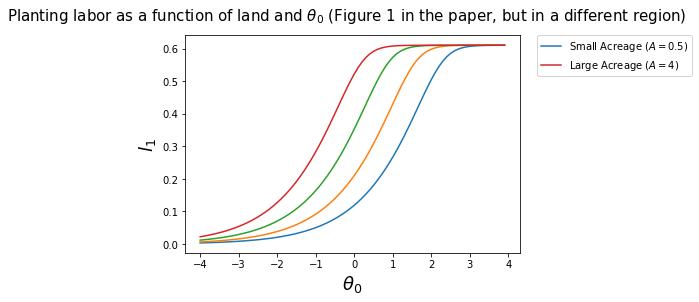

In [18]:
fig, ax = plt.subplots()
ax.plot(theta0_grid, l1_fig1[:,0], label = 'Small Acreage ($A = 0.5$)')
ax.plot(theta0_grid, l1_fig1[:,1])
ax.plot(theta0_grid, l1_fig1[:,2])
ax.plot(theta0_grid, l1_fig1[:,3], label = 'Large Acreage ($A = 4$)')
ax.set_xlabel(xlabel = '$\\theta_0$', fontsize = 18)
ax.set_ylabel(ylabel = '$l_1$', fontsize = 18)
fig.suptitle(
    'Planting labor as a function of land and $\\theta_0$ (Figure 1 in the paper, but in a different region)',
    fontsize = 15
)
ax.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', borderaxespad = 0.)
plt.show()

#### Figure 2

In [19]:
theta1_grid = np.arange(-3, 3, 0.1)
A_fig2 = 1
l2_fig2 = np.zeros((len(theta1_grid), 4))
for i, theta0_fig2 in enumerate([-2, -1, 1, 2]):
    l1_fig2 = scipy.optimize.brentq(
        Euler1_function, 1e-14, 1 - 1e-14, 
        args = (
            A_fig2, theta0_fig2 / sigma0, 
            [delta, sigma, rho, alpha, r1, beta, r2, b, sigma0, sigma1, sigma2]
        )
    )
    for j, theta1_fig2 in enumerate(theta1_grid):
        l2_fig2[j, i] = scipy.optimize.brentq(
            Euler2_function, 
            1e-14, 1 - 1e-14, 
            args = (
                theta1_fig2 / sigma1, l1_fig2, theta0_fig2 / sigma0, A_fig2, 
                [delta, sigma, rho, alpha, r1, beta, r2, b, sigma0, sigma1, sigma2]
            )
        )

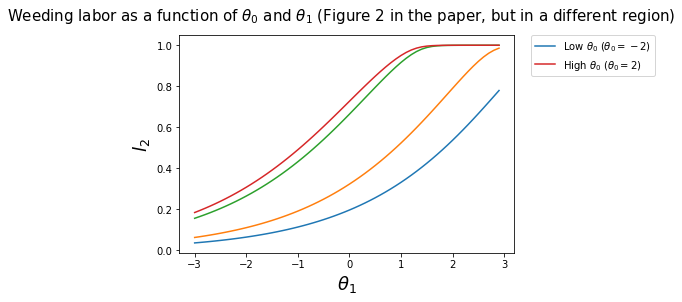

In [20]:
fig, ax = plt.subplots()
ax.plot(theta1_grid, l2_fig2[:,0], label = 'Low $\\theta_0$ ($\\theta_0 = -2$)')
ax.plot(theta1_grid, l2_fig2[:,1])
ax.plot(theta1_grid, l2_fig2[:,2])
ax.plot(theta1_grid, l2_fig2[:,3], label = 'High $\\theta_0$ ($\\theta_0 = 2$)')
ax.set_xlabel(xlabel = '$\\theta_1$', fontsize = 18)
ax.set_ylabel(ylabel = '$l_2$', fontsize = 18)
fig.suptitle(
    'Weeding labor as a function of $\\theta_0$ and $\\theta_1$ (Figure 2 in the paper, but in a different region)',
    fontsize = 15
)
ax.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', borderaxespad = 0.)
plt.show()